<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Olivia/DIST_GAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt
from math import floor



In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [5]:
class Net(nn.Module):
    def __init__(self, input_dim=1, output_dim=10, input_size=28, base_size=64):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size
        # self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.conv2 = nn.Conv2d(16, 128, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        # self.fc1 = nn.Linear(128 * 8 * 8, 512)
        # self.fc2 = nn.Linear(512, 128)
        # self.fc3 = nn.Linear(128, 10)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.ReLU(),
        )

        #initialize_weights(self)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = F.relu(self.conv3(x))
        # x = x.view(-1, 128 * 8 * 8)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

In [6]:
class Classifier():
    def __init__(self, epoch=20, batch_size=500):

        self.epoch_range = epoch
        self.batch_size = batch_size
        valid_ratio = 0.3

        nb_train = int((1.0 - valid_ratio) * len(train_dataset))
        nb_valid =  int(valid_ratio * len(train_dataset))
        train_split_dataset, valid_split_dataset = torch.utils.data.dataset.random_split(train_dataset, [nb_train, nb_valid])

        self.trainloader = torch.utils.data.DataLoader(train_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.validloader = torch.utils.data.DataLoader(valid_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.testloader = torch.utils.data.DataLoader(test_dataset, 
                                        batch_size=self.batch_size, 
                                        shuffle=False,
                                        num_workers=1)

        self.net = Net().cuda()

        self.criterion = nn.CrossEntropyLoss().cuda()

        self.optimizer = optim.Adam(self.net.parameters(), lr=0.00146)

        from google.colab import drive
        drive.mount('/content/drive')
        self.PATH = 'cifar10_net_test_3.pth'


        # Function to train the CNN classifier
#--------------------------------------------------------------------------------------------------------

    def train(self):

        self.training_loss = []
        self.validation_loss = []

        start_time = time.time()
        best_loss = np.float('inf')
        for epoch in range(self.epoch_range): 

            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                # inputs, labels = data[0].to(device), data[1].to(device)
                inputs, labels = data[0].cuda(), data[1].cuda()

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()

            epoch_loss = running_loss / (i+1)
            self.training_loss.append(epoch_loss)
            print("Epoch: ", epoch, " train loss: ", '%.3f' % epoch_loss)

            #---------------------------------

            with torch.no_grad(): 
                running_loss = 0.0

                for i, data in enumerate(self.validloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    #inputs, labels = data[0].to(device), data[1].to(device)
                    inputs, labels = data[0].cuda(), data[1].cuda()

                    # forward 
                    outputs = self.net(inputs)
                    loss = self.criterion(outputs, labels)

                    # print statistics
                    running_loss += loss.item()


                epoch_loss = running_loss / (i+1)
                self.validation_loss.append(epoch_loss)
                print("Epoch: ", epoch, " validation loss: ", '%.3f' % epoch_loss)

                # save the best model based on validation loss
                if epoch_loss < best_loss:
                    torch.save(self.net.state_dict(), self.PATH)
                    best_loss = epoch_loss

        time_elap = (time.time() - start_time) // 60
        print('Finished Training in %d mins' % time_elap)

        plt.plot(range(self.epoch_range), self.training_loss, 'k-')
        plt.title('train loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('train_loss')
        plt.show()

        plt.plot(range(self.epoch_range), self.validation_loss, 'k-')
        plt.title('validation loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('validation_loss')
        plt.show()


    def test_accuracy(self):

        correct = 0
        total = 0

        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                outputs = self.net(images.cuda())
                #print("Outputs shape:", outputs.shape)
                _, predicted = torch.max(outputs.data, 1)
                #print("predicted:", predicted.shape)
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum().item()

        print('Accuracy of the network on the 10000 test images: %.3F %%' % (
            100 * correct / total))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch:  0  train loss:  0.225
Epoch:  0  validation loss:  0.083
Epoch:  1  train loss:  0.064
Epoch:  1  validation loss:  0.061
Epoch:  2  train loss:  0.040
Epoch:  2  validation loss:  0.049
Epoch:  3  train loss:  0.028
Epoch:  3  validation loss:  0.050
Epoch:  4  train loss:  0.021
Epoch:  4  validation loss:  0.054
Epoch:  5  train loss:  0.017
Epoch:  5  validation loss:  0.046
Epoch:  6  train loss:  0.013
Epoch:  6  validation loss:  0.048
Epoch:  7  train loss:  0.011
Epoch:  7  validation loss:  0.048
Epoch:  8  train loss:  0.009
Epoch:  8  validation loss:  0.048
Epoch:  9  train loss:  0.008
Epoch:  9  validation loss:  0.048
Epoch:  10  train loss:  0.005
Epoch:  10  validation loss:  0.043
Epoch:  11  train loss:  0.004
Epoch:  11  validation loss:  0.047
Epoch:  12  train loss:  0.003
Epoch:  12  validation loss:  0.044
Epoch:  13  train lo

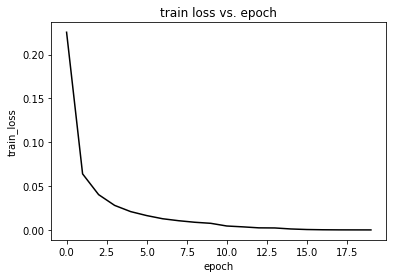

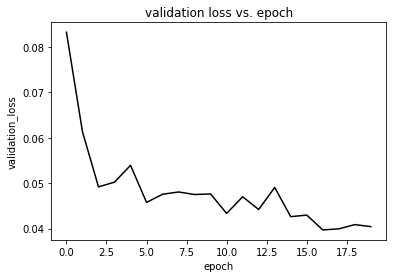

In [7]:
classifier = Classifier()
classifier.train()

In [8]:


def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
          s=ax[i].imshow(np.squeeze(samples[i,]))
          s=ax[i].get_xaxis().set_visible(False)
          s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [9]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [43]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        c =64
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=1)
        self.bn1 = nn.BatchNorm2d(c)
        self.bn2 = nn.BatchNorm2d(c*2)
        initialize_weights(self)   
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

In [17]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)           
    
    # forward method
    def forward(self, x): 
       # x = x.view(-1, self.input_size * self.input_size)
        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x




class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size



 
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            
        )
        self.Sig = nn.Sigmoid()

        initialize_weights(self)

     # forward method
  def forward(self, x):
        x = self.conv(x)
        y = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        logits  = self.fc(y) # logits 
        prob = self.Sig(logits) ## prob

        return prob,logits,x

In [11]:

# Sigmoid loss with logits, keep as tensor 
# z = labels , torch.ones_like discriminator sigmoid prob
# x =  discriminator logits prob 

def Sigmoid_logits_loss( logits,labels):
  z = labels
  x = logits 
  #z = z * -torch.log(torch.sigmoid(x)) + (1 - z) * -torch.log(1 - torch.sigmoid(x))
  #z = z * -torch.log(1 / (1 + torch.exp(-x))) + (1 - z) * -torch.log(torch.exp(-x) / (1 + torch.exp(-x)))
  #z = z * torch.log(1 + torch.exp(-x)) + (1 - z) * (-torch.log(torch.exp(-x)) + torch.log(1 + torch.exp(-x)))
  #z = z * torch.log(1 + torch.exp(-x)) + (1 - z) * (x + torch.log(1 + torch.exp(-x)))
  loss = 0
  for i, x in enumerate(x):
    for j, z in enumerate(z):
      if x >0:
        loss = x - x * z + torch.log(1 + torch.exp(-x))
      else:
        loss = - x * z + torch.log(1 + torch.exp(x))
      loss += loss
    return loss


In [32]:
def inception_score(gan, n_split=10, eps=1E-16):

      num_images = 100
      sample_z_ = torch.rand((num_images, gan.z_dim)).cuda()
      #print(sample_z_.shape)
      samples = gan.G(sample_z_)
      #print(samples.shape)

      samples_np = samples.cpu().data.numpy()

      # enumerate splits of images/predictions
      scores = list()
      n_part = floor(num_images / n_split)

      for i in range(n_part):
          # retrieve subset of images
          ix_start, ix_end = i * n_part, (i+1) * n_part
          subset = samples_np[ix_start:ix_end]
          # convert from uint8 to float32
          subset = subset.astype('float32')
          # predict p(y|x)
          outputs = classifier.net(torch.from_numpy(subset).cuda())
          outputs = F.softmax(outputs,dim=1)
          #print("outputs: ", outputs.shape)
          #print("\t", outputs)
          
          #y, p_yx = torch.max(outputs.data, 1)
          #print("p_yx: ", p_yx.shape)
          #print("\t", p_yx)
          #print(y.shape)
          p_yx_d = gan.D(torch.from_numpy(subset).cuda())
         # print("\tD: ", p_yx_d.shape)
          #print(p_yx.shape)
          #print(p_yx)
          p_yx = outputs.cpu().data.numpy()
         # print("p_yx numpy", p_yx)
          p_yx = np.expand_dims(p_yx, 0)
          #print(p_yx.shape)
         # print("p_yx expanded", p_yx)
          # calculate p(y)
          p_y = np.expand_dims(p_yx.mean(axis=1), 0)
          #print("p_y", p_y)
          # calculate KL divergence using log probabilities
          kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
         # print("kl_d", kl_d)
          # sum over classes
          sum_kl_d = kl_d.sum(axis=1)
          #print("sum_kl_d", sum_kl_d)
          # average over images
          avg_kl_d = np.mean(sum_kl_d)
          #print("avg_kl_d", avg_kl_d)
          # undo the log
          is_score = np.exp(avg_kl_d)
          #print("is_score", is_score)
          #print('\n\n')
		      # store
          scores.append(is_score)
        
      # average across images
      is_avg, is_std = np.mean(scores), np.std(scores)
      return is_avg,is_std
     
      #print(is_avg, is_std)

# Creating GAN Network

In [40]:

from torch.autograd import grad as torch_grad
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

     
        self.lamda_p = 1.0     # regularization term of gradient penalty
        self.lamda_r = 1.0    # autoencoders regularization term  
       
        
        
        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        print(data.shape[1])

        # initialization of the generator and discriminator and autoencoder 
        self.A = autoencoder().cuda()
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
      

        self.A_optimizer =  optim.Adam(self.A.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_d'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
      
    
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['IS_score'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                z_ = torch.rand((self.batch_size, self.z_dim))
               
                x_, z_ = x_.cuda() ,z_.cuda()
        
        

                #-------------Train Autoencoder & Generator to minimize reconstruction loss ------------# 
                # auto-encoders and its regularizatize 
                # zero the gradients 

                self.D_optimizer.zero_grad() 
                self.A_optimizer.zero_grad()
                # reconstructed image
                recon = self.A(x_)
                
                self.G_optimizer.zero_grad()
                X_r = self.G(recon) # reconstructed iamges from generator 
               # print("\tX_r:", X_r.shape)
                X_f = self.G(z_) # fake images from generator 
                #print("\tX_f:", X_f.shape)
                X_r, X_f = X_r, X_f
                
                
                D_real_prob, D_real_logits, D_real = self.D(x_)
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r)
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f)

                #print(D_real.shape)
                #print(x_.shape)

                ##auto-encoders and Regularization from Dist-Gan paper 

                R_loss = torch.mean(torch.square(D_real-D_recon))
                #print("\tR_loss:", R_loss.shape)
                f = torch.mean(D_recon - D_fake) #distance between reconstructed imgs and reconstructed fake imgs 
                #print("\tf:", f.shape)
                # w parmeter = sqrt(latent dim * 1/ feature dim ) = .1562 for 100
                # latent dim 1 wp = .01562
                # latent dim 10 wp = .04939

                wp = np.sqrt(self.z_dim/4096)
                g = torch.mean(recon - z_) * wp # distance between reconstruced imgs and noise # higher value = initial lowvD training loss  
                #print("\tg:", g.shape)
                R_reg = torch.square(f - g)

               
                # Train Autoencoder with R_loss 
                R_loss = R_loss + self.lamda_r * R_reg
                #print("\tR_loss", R_loss.shape)
                R_loss.backward()
                self.A_optimizer.step()
                
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())


                #Train Generator with G_Loss 
               
                G_loss = torch.abs(torch.mean(D_real_prob)- torch.mean(D_fake_prob))
                G_loss.backward()
                self.G_optimizer.step()



               #-----------Train Discriminator --------#######
                
                #Train Discriminator with Discriminator Score 
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())
                


                # interpolation     
                epsilon = torch.rand(x_.size())
                epsilon = epsilon.cuda()
                interpolation = x_ * epsilon + (1-epsilon) * X_f
                d_inter_prob, d_inter_logits, d_inter = self.D(interpolation)

                # Gradien Penalty 
                gradients = torch_grad(d_inter_logits, interpolation, grad_outputs=torch.ones(d_inter_logits.size()).cuda())[0]
              
                slopes = torch.sqrt(torch.mean(torch.square(gradients),1))
                gp = torch.mean((slopes-1)**2)
            
                #print(D_real_logits.shape)
            
                # Discriminator loss on data
                d_loss_real = torch.mean(Sigmoid_logits_loss( D_real_logits,torch.ones_like(D_real_prob)))
                d_loss_recon = torch.mean(Sigmoid_logits_loss(D_recon_logits, torch.ones_like(D_recon_prob)))
                d_loss_fake = torch.mean(Sigmoid_logits_loss(D_fake_logits,torch.zeros_like(D_fake_prob)))
               # print(d_loss_real.shape)

                # loss w.r.t gradient penalty and reconstruction term 
                D_loss = d_loss_real + d_loss_recon + d_loss_fake
                D_loss = D_loss + self.lamda_p * gp

          
              
                #train Discriminator
                
                D_loss.backward()
                self.D_optimizer.step()



                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
      
     
                #---------------Train Generator to minimize discriminator score --------#
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())
             
                #self.G_optimizer.zero_grad()
                G_loss = torch.abs(torch.mean(D_real_prob) - torch.mean(D_fake_prob))
                G_loss.backward()
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())
                
             
                # Print iterations and losses

                if ((iter + 1) % 50) == 0:
              
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
            # Visualize results
            if ((epoch + 1) % 1) == 0:
                with torch.no_grad():
                    visualize_results(self)
                

            with torch.no_grad():
                is_avg, _ = inception_score(self)
                self.train_hist['IS_score'].append(is_avg)
        
        print("Training finished!")

In [28]:
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils

def visualise_output(gan):

    with torch.no_grad():
        sample_z_ = torch.rand((gan.base_size, gan.z_dim)).cuda()
        samples = gan.G(sample_z_)
        samples = samples.cpu()
        samples = (samples + 1) / 2
        np_imagegrid = torchvision.utils.make_grid(samples[1:100], 10, 5).detach().numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()


1
training start!!
Epoch: [ 1] [  50/ 200] D_loss: 4.19464827, G_loss: 0.01955235
Epoch: [ 1] [ 100/ 200] D_loss: 6.35936117, G_loss: 0.01683927
Epoch: [ 1] [ 150/ 200] D_loss: 7.88772678, G_loss: 0.02766186
Epoch: [ 1] [ 200/ 200] D_loss: 4.06541967, G_loss: 0.00718278


<Figure size 72x720 with 0 Axes>

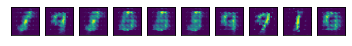

Epoch: [ 2] [  50/ 200] D_loss: 6.26468658, G_loss: 0.00700122
Epoch: [ 2] [ 100/ 200] D_loss: 5.69511986, G_loss: 0.00631869
Epoch: [ 2] [ 150/ 200] D_loss: 7.11614990, G_loss: 0.00309730
Epoch: [ 2] [ 200/ 200] D_loss: 5.47077560, G_loss: 0.00170773


<Figure size 72x720 with 0 Axes>

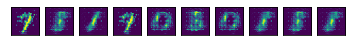

Epoch: [ 3] [  50/ 200] D_loss: 3.70626283, G_loss: 0.00178826
Epoch: [ 3] [ 100/ 200] D_loss: 5.60979557, G_loss: 0.00147688
Epoch: [ 3] [ 150/ 200] D_loss: 5.65562630, G_loss: 0.01498842
Epoch: [ 3] [ 200/ 200] D_loss: 5.05897236, G_loss: 0.01249486


<Figure size 72x720 with 0 Axes>

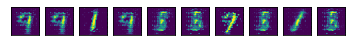

Epoch: [ 4] [  50/ 200] D_loss: 5.34177923, G_loss: 0.00228548
Epoch: [ 4] [ 100/ 200] D_loss: 5.03558731, G_loss: 0.00390452
Epoch: [ 4] [ 150/ 200] D_loss: 4.85907984, G_loss: 0.00228089
Epoch: [ 4] [ 200/ 200] D_loss: 4.28511095, G_loss: 0.00925153


<Figure size 72x720 with 0 Axes>

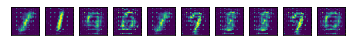

Epoch: [ 5] [  50/ 200] D_loss: 4.96146488, G_loss: 0.01687425
Epoch: [ 5] [ 100/ 200] D_loss: 8.46967125, G_loss: 0.00782520
Epoch: [ 5] [ 150/ 200] D_loss: 6.24705982, G_loss: 0.01366597
Epoch: [ 5] [ 200/ 200] D_loss: 4.60285187, G_loss: 0.01890409


<Figure size 72x720 with 0 Axes>

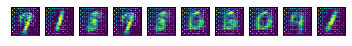

Epoch: [ 6] [  50/ 200] D_loss: 4.81118202, G_loss: 0.02815372
Epoch: [ 6] [ 100/ 200] D_loss: 4.39667368, G_loss: 0.03413385
Epoch: [ 6] [ 150/ 200] D_loss: 4.68229818, G_loss: 0.03768194
Epoch: [ 6] [ 200/ 200] D_loss: 5.04460144, G_loss: 0.05906701


<Figure size 72x720 with 0 Axes>

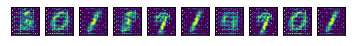

Epoch: [ 7] [  50/ 200] D_loss: 4.89251566, G_loss: 0.04899269
Epoch: [ 7] [ 100/ 200] D_loss: 4.55464172, G_loss: 0.05659622
Epoch: [ 7] [ 150/ 200] D_loss: 4.63802671, G_loss: 0.05875164
Epoch: [ 7] [ 200/ 200] D_loss: 3.36881375, G_loss: 0.05839401


<Figure size 72x720 with 0 Axes>

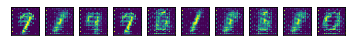

Epoch: [ 8] [  50/ 200] D_loss: 3.73885560, G_loss: 0.05182135
Epoch: [ 8] [ 100/ 200] D_loss: 5.25617075, G_loss: 0.07336009
Epoch: [ 8] [ 150/ 200] D_loss: 3.24862862, G_loss: 0.09756887
Epoch: [ 8] [ 200/ 200] D_loss: 3.57658124, G_loss: 0.10264641


<Figure size 72x720 with 0 Axes>

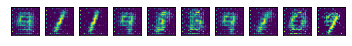

Epoch: [ 9] [  50/ 200] D_loss: 3.92787790, G_loss: 0.13677663
Epoch: [ 9] [ 100/ 200] D_loss: 2.97011137, G_loss: 0.11888456
Epoch: [ 9] [ 150/ 200] D_loss: 4.20801830, G_loss: 0.11284941
Epoch: [ 9] [ 200/ 200] D_loss: 5.02603769, G_loss: 0.14410907


<Figure size 72x720 with 0 Axes>

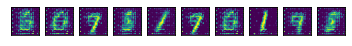

Epoch: [10] [  50/ 200] D_loss: 8.50387669, G_loss: 0.14559442
Epoch: [10] [ 100/ 200] D_loss: 4.57229662, G_loss: 0.21789569
Epoch: [10] [ 150/ 200] D_loss: 3.48188281, G_loss: 0.21353117
Epoch: [10] [ 200/ 200] D_loss: 2.81057954, G_loss: 0.22949880


<Figure size 72x720 with 0 Axes>

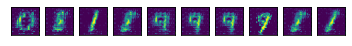

Epoch: [11] [  50/ 200] D_loss: 2.70739579, G_loss: 0.21086591
Epoch: [11] [ 100/ 200] D_loss: 2.55648565, G_loss: 0.24156088
Epoch: [11] [ 150/ 200] D_loss: 2.71622467, G_loss: 0.24175596
Epoch: [11] [ 200/ 200] D_loss: 3.56932449, G_loss: 0.27711484


<Figure size 72x720 with 0 Axes>

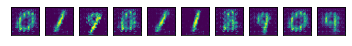

Epoch: [12] [  50/ 200] D_loss: 4.51732302, G_loss: 0.28294027
Epoch: [12] [ 100/ 200] D_loss: 1.73151040, G_loss: 0.28011313
Epoch: [12] [ 150/ 200] D_loss: 3.18917036, G_loss: 0.26809758
Epoch: [12] [ 200/ 200] D_loss: 2.79465103, G_loss: 0.22182053


<Figure size 72x720 with 0 Axes>

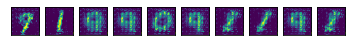

Epoch: [13] [  50/ 200] D_loss: 2.53231311, G_loss: 0.33707094
Epoch: [13] [ 100/ 200] D_loss: 2.41154337, G_loss: 0.28352958
Epoch: [13] [ 150/ 200] D_loss: 4.30388403, G_loss: 0.30879697
Epoch: [13] [ 200/ 200] D_loss: 2.36882162, G_loss: 0.33031216


<Figure size 72x720 with 0 Axes>

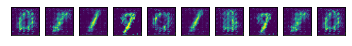

Epoch: [14] [  50/ 200] D_loss: 3.08325052, G_loss: 0.31175706
Epoch: [14] [ 100/ 200] D_loss: 2.65643597, G_loss: 0.41200247
Epoch: [14] [ 150/ 200] D_loss: 2.12740374, G_loss: 0.43213937
Epoch: [14] [ 200/ 200] D_loss: 3.07501912, G_loss: 0.38716054


<Figure size 72x720 with 0 Axes>

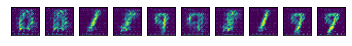

Epoch: [15] [  50/ 200] D_loss: 5.37508392, G_loss: 0.31987312
Epoch: [15] [ 100/ 200] D_loss: 2.09771895, G_loss: 0.44816715
Epoch: [15] [ 150/ 200] D_loss: 9.19612980, G_loss: 0.31321090
Epoch: [15] [ 200/ 200] D_loss: 2.53423119, G_loss: 0.40023512


<Figure size 72x720 with 0 Axes>

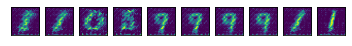

Epoch: [16] [  50/ 200] D_loss: 2.58615494, G_loss: 0.36518008
Epoch: [16] [ 100/ 200] D_loss: 1.86403942, G_loss: 0.37121928
Epoch: [16] [ 150/ 200] D_loss: 3.55452728, G_loss: 0.47826535
Epoch: [16] [ 200/ 200] D_loss: 1.49635553, G_loss: 0.40182391


<Figure size 72x720 with 0 Axes>

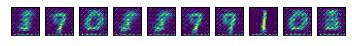

Epoch: [17] [  50/ 200] D_loss: 4.50724459, G_loss: 0.43885341
Epoch: [17] [ 100/ 200] D_loss: 1.07221842, G_loss: 0.44672057
Epoch: [17] [ 150/ 200] D_loss: 2.99159837, G_loss: 0.51288050
Epoch: [17] [ 200/ 200] D_loss: 2.38746619, G_loss: 0.49820486


<Figure size 72x720 with 0 Axes>

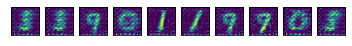

Epoch: [18] [  50/ 200] D_loss: 2.23455787, G_loss: 0.56408852
Epoch: [18] [ 100/ 200] D_loss: 1.76086962, G_loss: 0.45716965
Epoch: [18] [ 150/ 200] D_loss: 4.52424812, G_loss: 0.44928890
Epoch: [18] [ 200/ 200] D_loss: 5.25294495, G_loss: 0.41178614


<Figure size 72x720 with 0 Axes>

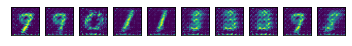

Epoch: [19] [  50/ 200] D_loss: 3.99977016, G_loss: 0.54127562
Epoch: [19] [ 100/ 200] D_loss: 1.74898982, G_loss: 0.49893218
Epoch: [19] [ 150/ 200] D_loss: 2.77858186, G_loss: 0.48686662
Epoch: [19] [ 200/ 200] D_loss: 1.52705014, G_loss: 0.53421384


<Figure size 72x720 with 0 Axes>

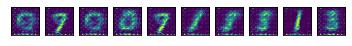

Epoch: [20] [  50/ 200] D_loss: 1.20565248, G_loss: 0.53262472
Epoch: [20] [ 100/ 200] D_loss: 3.20437217, G_loss: 0.55303580
Epoch: [20] [ 150/ 200] D_loss: 1.68395138, G_loss: 0.52221191
Epoch: [20] [ 200/ 200] D_loss: 1.57732677, G_loss: 0.56607795


<Figure size 72x720 with 0 Axes>

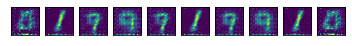

Epoch: [21] [  50/ 200] D_loss: 2.60278463, G_loss: 0.60362852
Epoch: [21] [ 100/ 200] D_loss: 2.55103922, G_loss: 0.45528087
Epoch: [21] [ 150/ 200] D_loss: 2.25846386, G_loss: 0.56446981
Epoch: [21] [ 200/ 200] D_loss: 2.42668080, G_loss: 0.56731749


<Figure size 72x720 with 0 Axes>

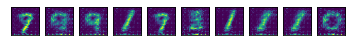

Epoch: [22] [  50/ 200] D_loss: 4.91661263, G_loss: 0.53356051
Epoch: [22] [ 100/ 200] D_loss: 1.92489886, G_loss: 0.53085196
Epoch: [22] [ 150/ 200] D_loss: 1.02422047, G_loss: 0.51425552
Epoch: [22] [ 200/ 200] D_loss: 1.26666260, G_loss: 0.44997719


<Figure size 72x720 with 0 Axes>

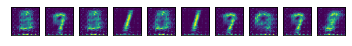

Epoch: [23] [  50/ 200] D_loss: 3.38124919, G_loss: 0.57325816
Epoch: [23] [ 100/ 200] D_loss: 4.25538635, G_loss: 0.61459273
Epoch: [23] [ 150/ 200] D_loss: 2.93093204, G_loss: 0.58106554
Epoch: [23] [ 200/ 200] D_loss: 1.60575247, G_loss: 0.60925347


<Figure size 72x720 with 0 Axes>

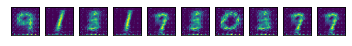

Epoch: [24] [  50/ 200] D_loss: 1.51643252, G_loss: 0.51541334
Epoch: [24] [ 100/ 200] D_loss: 2.80285335, G_loss: 0.55379099
Epoch: [24] [ 150/ 200] D_loss: 1.17578983, G_loss: 0.58930790
Epoch: [24] [ 200/ 200] D_loss: 1.34798932, G_loss: 0.65458310


<Figure size 72x720 with 0 Axes>

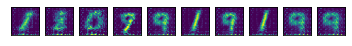

Epoch: [25] [  50/ 200] D_loss: 0.97921312, G_loss: 0.57976389
Epoch: [25] [ 100/ 200] D_loss: 1.22108078, G_loss: 0.59888178
Epoch: [25] [ 150/ 200] D_loss: 1.50221181, G_loss: 0.60950929
Epoch: [25] [ 200/ 200] D_loss: 1.96183586, G_loss: 0.59136760


<Figure size 72x720 with 0 Axes>

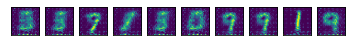

Epoch: [26] [  50/ 200] D_loss: 1.61327505, G_loss: 0.67607969
Epoch: [26] [ 100/ 200] D_loss: 1.71790028, G_loss: 0.66597658
Epoch: [26] [ 150/ 200] D_loss: 1.23841095, G_loss: 0.55113518
Epoch: [26] [ 200/ 200] D_loss: 5.46122074, G_loss: 0.55672896


<Figure size 72x720 with 0 Axes>

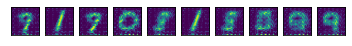

Epoch: [27] [  50/ 200] D_loss: 1.40892839, G_loss: 0.60196573
Epoch: [27] [ 100/ 200] D_loss: 1.18404937, G_loss: 0.52521622
Epoch: [27] [ 150/ 200] D_loss: 8.21815014, G_loss: 0.51069629
Epoch: [27] [ 200/ 200] D_loss: 1.92175841, G_loss: 0.56703287


<Figure size 72x720 with 0 Axes>

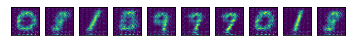

Epoch: [28] [  50/ 200] D_loss: 1.84412682, G_loss: 0.66920400
Epoch: [28] [ 100/ 200] D_loss: 3.72888541, G_loss: 0.57068670
Epoch: [28] [ 150/ 200] D_loss: 2.54202700, G_loss: 0.62773621
Epoch: [28] [ 200/ 200] D_loss: 2.51130319, G_loss: 0.64140379


<Figure size 72x720 with 0 Axes>

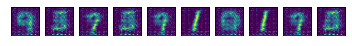

Epoch: [29] [  50/ 200] D_loss: 1.43945050, G_loss: 0.64736497
Epoch: [29] [ 100/ 200] D_loss: 2.64031434, G_loss: 0.62912369
Epoch: [29] [ 150/ 200] D_loss: 0.98576474, G_loss: 0.68078309
Epoch: [29] [ 200/ 200] D_loss: 7.41167355, G_loss: 0.67667997


<Figure size 72x720 with 0 Axes>

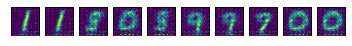

Epoch: [30] [  50/ 200] D_loss: 1.51509094, G_loss: 0.60261935
Epoch: [30] [ 100/ 200] D_loss: 2.68219185, G_loss: 0.66980779
Epoch: [30] [ 150/ 200] D_loss: 2.04274702, G_loss: 0.68509752
Epoch: [30] [ 200/ 200] D_loss: 1.62490845, G_loss: 0.73776501


<Figure size 72x720 with 0 Axes>

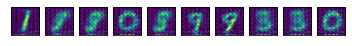

Epoch: [31] [  50/ 200] D_loss: 0.88301522, G_loss: 0.70923561
Epoch: [31] [ 100/ 200] D_loss: 1.19806099, G_loss: 0.62369347
Epoch: [31] [ 150/ 200] D_loss: 1.18263113, G_loss: 0.68900573
Epoch: [31] [ 200/ 200] D_loss: 1.26877391, G_loss: 0.64781553


<Figure size 72x720 with 0 Axes>

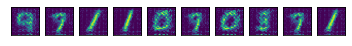

Epoch: [32] [  50/ 200] D_loss: 3.05205655, G_loss: 0.66610038
Epoch: [32] [ 100/ 200] D_loss: 2.22584867, G_loss: 0.58518493
Epoch: [32] [ 150/ 200] D_loss: 0.95743346, G_loss: 0.60564262
Epoch: [32] [ 200/ 200] D_loss: 1.61463654, G_loss: 0.68251765


<Figure size 72x720 with 0 Axes>

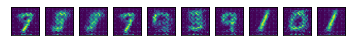

Epoch: [33] [  50/ 200] D_loss: 1.30463278, G_loss: 0.68502557
Epoch: [33] [ 100/ 200] D_loss: 1.59099865, G_loss: 0.62577271
Epoch: [33] [ 150/ 200] D_loss: 1.51427722, G_loss: 0.65921026
Epoch: [33] [ 200/ 200] D_loss: 1.22373867, G_loss: 0.71598035


<Figure size 72x720 with 0 Axes>

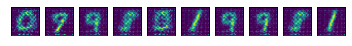

Epoch: [34] [  50/ 200] D_loss: 1.16110349, G_loss: 0.64444792
Epoch: [34] [ 100/ 200] D_loss: 1.82341826, G_loss: 0.68100542
Epoch: [34] [ 150/ 200] D_loss: 1.93710315, G_loss: 0.67642486
Epoch: [34] [ 200/ 200] D_loss: 2.01873350, G_loss: 0.65899730


<Figure size 72x720 with 0 Axes>

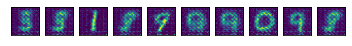

Epoch: [35] [  50/ 200] D_loss: 1.73183966, G_loss: 0.67957467
Epoch: [35] [ 100/ 200] D_loss: 1.69913507, G_loss: 0.55496204
Epoch: [35] [ 150/ 200] D_loss: 1.20237303, G_loss: 0.65254837
Epoch: [35] [ 200/ 200] D_loss: 2.02654934, G_loss: 0.60250849


<Figure size 72x720 with 0 Axes>

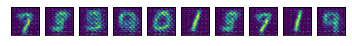

Epoch: [36] [  50/ 200] D_loss: 1.51407528, G_loss: 0.61063504
Epoch: [36] [ 100/ 200] D_loss: 2.23679662, G_loss: 0.61088657
Epoch: [36] [ 150/ 200] D_loss: 3.49556661, G_loss: 0.70964438
Epoch: [36] [ 200/ 200] D_loss: 1.10965466, G_loss: 0.69504404


<Figure size 72x720 with 0 Axes>

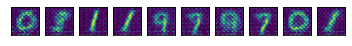

Epoch: [37] [  50/ 200] D_loss: 1.05301547, G_loss: 0.61658245
Epoch: [37] [ 100/ 200] D_loss: 1.72743583, G_loss: 0.62763268
Epoch: [37] [ 150/ 200] D_loss: 1.96049511, G_loss: 0.64959383
Epoch: [37] [ 200/ 200] D_loss: 1.06261086, G_loss: 0.68786776


<Figure size 72x720 with 0 Axes>

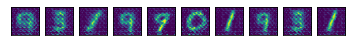

Epoch: [38] [  50/ 200] D_loss: 2.64090919, G_loss: 0.70190859
Epoch: [38] [ 100/ 200] D_loss: 0.94453907, G_loss: 0.72294879
Epoch: [38] [ 150/ 200] D_loss: 2.29973054, G_loss: 0.73400873
Epoch: [38] [ 200/ 200] D_loss: 1.55091143, G_loss: 0.70622051


<Figure size 72x720 with 0 Axes>

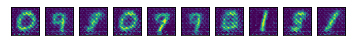

Epoch: [39] [  50/ 200] D_loss: 1.72525048, G_loss: 0.70280904
Epoch: [39] [ 100/ 200] D_loss: 2.14544725, G_loss: 0.69437766
Epoch: [39] [ 150/ 200] D_loss: 1.31232715, G_loss: 0.75814605
Epoch: [39] [ 200/ 200] D_loss: 3.94591379, G_loss: 0.64634579


<Figure size 72x720 with 0 Axes>

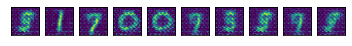

Epoch: [40] [  50/ 200] D_loss: 0.83799630, G_loss: 0.62978327
Epoch: [40] [ 100/ 200] D_loss: 1.25764108, G_loss: 0.70456737
Epoch: [40] [ 150/ 200] D_loss: 1.28765869, G_loss: 0.67388356
Epoch: [40] [ 200/ 200] D_loss: 1.88909149, G_loss: 0.55905992


<Figure size 72x720 with 0 Axes>

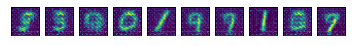

Epoch: [41] [  50/ 200] D_loss: 1.25642586, G_loss: 0.70236242
Epoch: [41] [ 100/ 200] D_loss: 2.09107804, G_loss: 0.53175819
Epoch: [41] [ 150/ 200] D_loss: 0.90690774, G_loss: 0.64590329
Epoch: [41] [ 200/ 200] D_loss: 3.84633899, G_loss: 0.62055242


<Figure size 72x720 with 0 Axes>

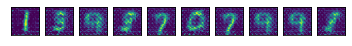

Epoch: [42] [  50/ 200] D_loss: 1.02577174, G_loss: 0.61489934
Epoch: [42] [ 100/ 200] D_loss: 1.46538591, G_loss: 0.67629158
Epoch: [42] [ 150/ 200] D_loss: 3.45742464, G_loss: 0.71177149
Epoch: [42] [ 200/ 200] D_loss: 2.13021708, G_loss: 0.68249625


<Figure size 72x720 with 0 Axes>

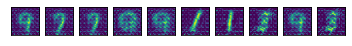

Epoch: [43] [  50/ 200] D_loss: 0.99144012, G_loss: 0.62416756
Epoch: [43] [ 100/ 200] D_loss: 1.28738916, G_loss: 0.73181576
Epoch: [43] [ 150/ 200] D_loss: 0.97953391, G_loss: 0.58073837
Epoch: [43] [ 200/ 200] D_loss: 1.27866220, G_loss: 0.70490032


<Figure size 72x720 with 0 Axes>

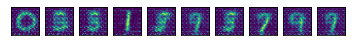

Epoch: [44] [  50/ 200] D_loss: 1.46522617, G_loss: 0.64476681
Epoch: [44] [ 100/ 200] D_loss: 1.20845461, G_loss: 0.75892508
Epoch: [44] [ 150/ 200] D_loss: 1.43054557, G_loss: 0.72752863
Epoch: [44] [ 200/ 200] D_loss: 2.19157648, G_loss: 0.61510193


<Figure size 72x720 with 0 Axes>

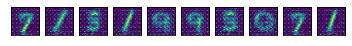

Epoch: [45] [  50/ 200] D_loss: 1.87015104, G_loss: 0.69881082
Epoch: [45] [ 100/ 200] D_loss: 9.47526455, G_loss: 0.68272322
Epoch: [45] [ 150/ 200] D_loss: 1.23827052, G_loss: 0.70820230
Epoch: [45] [ 200/ 200] D_loss: 5.22648573, G_loss: 0.67819917


<Figure size 72x720 with 0 Axes>

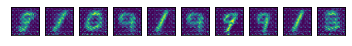

Epoch: [46] [  50/ 200] D_loss: 7.04487324, G_loss: 0.67479241
Epoch: [46] [ 100/ 200] D_loss: 1.09269273, G_loss: 0.70270336
Epoch: [46] [ 150/ 200] D_loss: 1.02487767, G_loss: 0.63726079
Epoch: [46] [ 200/ 200] D_loss: 2.15360999, G_loss: 0.65364337


<Figure size 72x720 with 0 Axes>

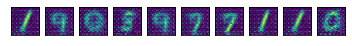

Epoch: [47] [  50/ 200] D_loss: 1.43369293, G_loss: 0.63480616
Epoch: [47] [ 100/ 200] D_loss: 2.53340578, G_loss: 0.66546661
Epoch: [47] [ 150/ 200] D_loss: 1.41450918, G_loss: 0.77317190
Epoch: [47] [ 200/ 200] D_loss: 1.59209919, G_loss: 0.76942384


<Figure size 72x720 with 0 Axes>

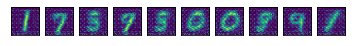

Epoch: [48] [  50/ 200] D_loss: 2.80075431, G_loss: 0.60605603
Epoch: [48] [ 100/ 200] D_loss: 1.13537765, G_loss: 0.55471832
Epoch: [48] [ 150/ 200] D_loss: 1.91108811, G_loss: 0.67822915
Epoch: [48] [ 200/ 200] D_loss: 3.56713724, G_loss: 0.55608165


<Figure size 72x720 with 0 Axes>

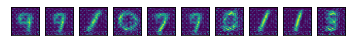

Epoch: [49] [  50/ 200] D_loss: 2.88229465, G_loss: 0.72030628
Epoch: [49] [ 100/ 200] D_loss: 1.34229779, G_loss: 0.74247044
Epoch: [49] [ 150/ 200] D_loss: 1.24117410, G_loss: 0.74794704
Epoch: [49] [ 200/ 200] D_loss: 1.26259685, G_loss: 0.76139534


<Figure size 72x720 with 0 Axes>

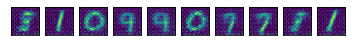

Epoch: [50] [  50/ 200] D_loss: 1.68622899, G_loss: 0.60796344
Epoch: [50] [ 100/ 200] D_loss: 1.13468552, G_loss: 0.76451051
Epoch: [50] [ 150/ 200] D_loss: 2.09504747, G_loss: 0.73493022
Epoch: [50] [ 200/ 200] D_loss: 1.11456990, G_loss: 0.73718286


<Figure size 72x720 with 0 Axes>

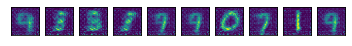

Epoch: [51] [  50/ 200] D_loss: 1.11497831, G_loss: 0.63452506
Epoch: [51] [ 100/ 200] D_loss: 1.28750587, G_loss: 0.75403649
Epoch: [51] [ 150/ 200] D_loss: 1.28988492, G_loss: 0.62163663
Epoch: [51] [ 200/ 200] D_loss: 1.56120086, G_loss: 0.69930029


<Figure size 72x720 with 0 Axes>

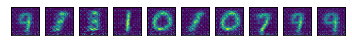

Epoch: [52] [  50/ 200] D_loss: 1.05451012, G_loss: 0.70124859
Epoch: [52] [ 100/ 200] D_loss: 1.03048038, G_loss: 0.68139249
Epoch: [52] [ 150/ 200] D_loss: 1.11099386, G_loss: 0.70203596
Epoch: [52] [ 200/ 200] D_loss: 1.05353439, G_loss: 0.76233816


<Figure size 72x720 with 0 Axes>

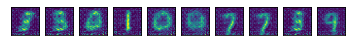

Epoch: [53] [  50/ 200] D_loss: 1.47469521, G_loss: 0.73985732
Epoch: [53] [ 100/ 200] D_loss: 1.44775629, G_loss: 0.59258986
Epoch: [53] [ 150/ 200] D_loss: 0.99810135, G_loss: 0.68511569
Epoch: [53] [ 200/ 200] D_loss: 1.01105011, G_loss: 0.73341018


<Figure size 72x720 with 0 Axes>

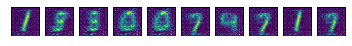

Epoch: [54] [  50/ 200] D_loss: 2.02958369, G_loss: 0.58648109
Epoch: [54] [ 100/ 200] D_loss: 2.08521867, G_loss: 0.70778710
Epoch: [54] [ 150/ 200] D_loss: 1.11787820, G_loss: 0.74818128
Epoch: [54] [ 200/ 200] D_loss: 1.07817340, G_loss: 0.74240708


<Figure size 72x720 with 0 Axes>

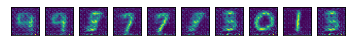

Epoch: [55] [  50/ 200] D_loss: 1.76096177, G_loss: 0.74438030
Epoch: [55] [ 100/ 200] D_loss: 1.97144413, G_loss: 0.74028152
Epoch: [55] [ 150/ 200] D_loss: 1.75462902, G_loss: 0.68412906
Epoch: [55] [ 200/ 200] D_loss: 1.59854889, G_loss: 0.66115862


<Figure size 72x720 with 0 Axes>

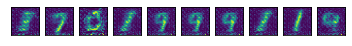

Epoch: [56] [  50/ 200] D_loss: 4.00143814, G_loss: 0.76298487
Epoch: [56] [ 100/ 200] D_loss: 1.67804742, G_loss: 0.72904438
Epoch: [56] [ 150/ 200] D_loss: 1.08156443, G_loss: 0.66822100
Epoch: [56] [ 200/ 200] D_loss: 2.11922193, G_loss: 0.76202089


<Figure size 72x720 with 0 Axes>

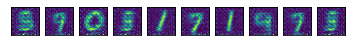

Epoch: [57] [  50/ 200] D_loss: 1.07038760, G_loss: 0.71142894
Epoch: [57] [ 100/ 200] D_loss: 1.09910417, G_loss: 0.76761907
Epoch: [57] [ 150/ 200] D_loss: 2.66503906, G_loss: 0.58185768
Epoch: [57] [ 200/ 200] D_loss: 1.58919466, G_loss: 0.72620291


<Figure size 72x720 with 0 Axes>

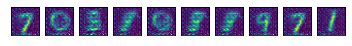

Epoch: [58] [  50/ 200] D_loss: 0.93926704, G_loss: 0.80348498
Epoch: [58] [ 100/ 200] D_loss: 1.34088647, G_loss: 0.59409720
Epoch: [58] [ 150/ 200] D_loss: 1.07971907, G_loss: 0.71531367
Epoch: [58] [ 200/ 200] D_loss: 1.27527368, G_loss: 0.71080756


<Figure size 72x720 with 0 Axes>

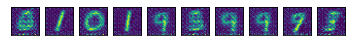

Epoch: [59] [  50/ 200] D_loss: 1.06362939, G_loss: 0.69871342
Epoch: [59] [ 100/ 200] D_loss: 1.16896629, G_loss: 0.78884137
Epoch: [59] [ 150/ 200] D_loss: 0.97427374, G_loss: 0.78129393
Epoch: [59] [ 200/ 200] D_loss: 10.96604824, G_loss: 0.70701063


<Figure size 72x720 with 0 Axes>

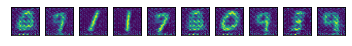

Epoch: [60] [  50/ 200] D_loss: 8.06829166, G_loss: 0.71211267
Epoch: [60] [ 100/ 200] D_loss: 1.22914124, G_loss: 0.71516430
Epoch: [60] [ 150/ 200] D_loss: 1.47201443, G_loss: 0.76809680
Epoch: [60] [ 200/ 200] D_loss: 1.73213005, G_loss: 0.66856116


<Figure size 72x720 with 0 Axes>

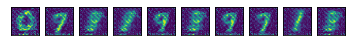

Epoch: [61] [  50/ 200] D_loss: 1.17347467, G_loss: 0.76144791
Epoch: [61] [ 100/ 200] D_loss: 1.16104496, G_loss: 0.64482570
Epoch: [61] [ 150/ 200] D_loss: 1.05007553, G_loss: 0.72733223
Epoch: [61] [ 200/ 200] D_loss: 1.22577238, G_loss: 0.68485570


<Figure size 72x720 with 0 Axes>

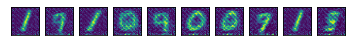

Epoch: [62] [  50/ 200] D_loss: 0.84955072, G_loss: 0.80294150
Epoch: [62] [ 100/ 200] D_loss: 1.06345904, G_loss: 0.76592577
Epoch: [62] [ 150/ 200] D_loss: 1.96223104, G_loss: 0.57594967
Epoch: [62] [ 200/ 200] D_loss: 1.06829464, G_loss: 0.68084741


<Figure size 72x720 with 0 Axes>

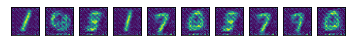

Epoch: [63] [  50/ 200] D_loss: 4.45005989, G_loss: 0.64929020
Epoch: [63] [ 100/ 200] D_loss: 1.65290761, G_loss: 0.78879076
Epoch: [63] [ 150/ 200] D_loss: 0.95097643, G_loss: 0.73217040
Epoch: [63] [ 200/ 200] D_loss: 0.97724962, G_loss: 0.72309601


<Figure size 72x720 with 0 Axes>

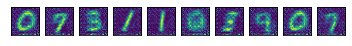

Epoch: [64] [  50/ 200] D_loss: 0.90002608, G_loss: 0.74471366
Epoch: [64] [ 100/ 200] D_loss: 1.00488234, G_loss: 0.62641883
Epoch: [64] [ 150/ 200] D_loss: 1.35715580, G_loss: 0.73512030
Epoch: [64] [ 200/ 200] D_loss: 0.98631728, G_loss: 0.69022095


<Figure size 72x720 with 0 Axes>

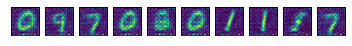

Epoch: [65] [  50/ 200] D_loss: 0.82017815, G_loss: 0.63221419
Epoch: [65] [ 100/ 200] D_loss: 0.93117613, G_loss: 0.76875687
Epoch: [65] [ 150/ 200] D_loss: 1.54677629, G_loss: 0.75881708
Epoch: [65] [ 200/ 200] D_loss: 1.68279207, G_loss: 0.52191561


<Figure size 72x720 with 0 Axes>

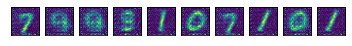

Epoch: [66] [  50/ 200] D_loss: 1.44780707, G_loss: 0.66370058
Epoch: [66] [ 100/ 200] D_loss: 0.91251278, G_loss: 0.68912160
Epoch: [66] [ 150/ 200] D_loss: 1.13529921, G_loss: 0.68815827
Epoch: [66] [ 200/ 200] D_loss: 1.34374642, G_loss: 0.65795600


<Figure size 72x720 with 0 Axes>

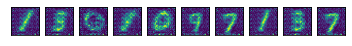

Epoch: [67] [  50/ 200] D_loss: 0.95154965, G_loss: 0.72815812
Epoch: [67] [ 100/ 200] D_loss: 1.55835152, G_loss: 0.69290531
Epoch: [67] [ 150/ 200] D_loss: 1.82434702, G_loss: 0.73680091
Epoch: [67] [ 200/ 200] D_loss: 1.29447246, G_loss: 0.68811947


<Figure size 72x720 with 0 Axes>

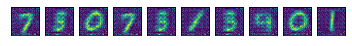

Epoch: [68] [  50/ 200] D_loss: 1.03323662, G_loss: 0.73888820
Epoch: [68] [ 100/ 200] D_loss: 1.64178479, G_loss: 0.77254844
Epoch: [68] [ 150/ 200] D_loss: 1.57537174, G_loss: 0.75633746
Epoch: [68] [ 200/ 200] D_loss: 2.59336805, G_loss: 0.78721207


<Figure size 72x720 with 0 Axes>

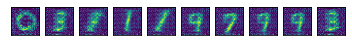

Epoch: [69] [  50/ 200] D_loss: 0.98587132, G_loss: 0.55745411
Epoch: [69] [ 100/ 200] D_loss: 0.91169190, G_loss: 0.76561046
Epoch: [69] [ 150/ 200] D_loss: 1.24741185, G_loss: 0.75849879
Epoch: [69] [ 200/ 200] D_loss: 0.87536782, G_loss: 0.77075946


<Figure size 72x720 with 0 Axes>

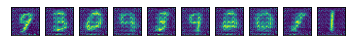

Epoch: [70] [  50/ 200] D_loss: 0.89546782, G_loss: 0.74399316
Epoch: [70] [ 100/ 200] D_loss: 1.69191027, G_loss: 0.68042326
Epoch: [70] [ 150/ 200] D_loss: 0.88129956, G_loss: 0.77866721
Epoch: [70] [ 200/ 200] D_loss: 0.98991716, G_loss: 0.77226126


<Figure size 72x720 with 0 Axes>

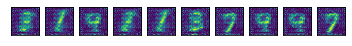

Epoch: [71] [  50/ 200] D_loss: 1.45814252, G_loss: 0.78556663
Epoch: [71] [ 100/ 200] D_loss: 3.42746592, G_loss: 0.72052377
Epoch: [71] [ 150/ 200] D_loss: 1.18793011, G_loss: 0.69281733
Epoch: [71] [ 200/ 200] D_loss: 0.93072802, G_loss: 0.78656733


<Figure size 72x720 with 0 Axes>

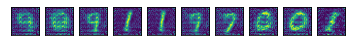

Epoch: [72] [  50/ 200] D_loss: 1.38212109, G_loss: 0.70876539
Epoch: [72] [ 100/ 200] D_loss: 1.02189934, G_loss: 0.81732637
Epoch: [72] [ 150/ 200] D_loss: 3.46044207, G_loss: 0.75748408
Epoch: [72] [ 200/ 200] D_loss: 1.03326643, G_loss: 0.74319410


<Figure size 72x720 with 0 Axes>

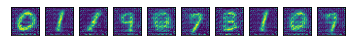

Epoch: [73] [  50/ 200] D_loss: 2.89203548, G_loss: 0.73508811
Epoch: [73] [ 100/ 200] D_loss: 1.28475285, G_loss: 0.72329664
Epoch: [73] [ 150/ 200] D_loss: 1.06951761, G_loss: 0.77600598
Epoch: [73] [ 200/ 200] D_loss: 1.24650514, G_loss: 0.81502521


<Figure size 72x720 with 0 Axes>

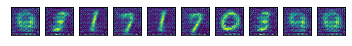

Epoch: [74] [  50/ 200] D_loss: 2.11688852, G_loss: 0.73601186
Epoch: [74] [ 100/ 200] D_loss: 6.01246929, G_loss: 0.68095052
Epoch: [74] [ 150/ 200] D_loss: 0.97196722, G_loss: 0.63757664
Epoch: [74] [ 200/ 200] D_loss: 1.35283709, G_loss: 0.53933471


<Figure size 72x720 with 0 Axes>

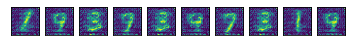

Epoch: [75] [  50/ 200] D_loss: 1.05790639, G_loss: 0.68242931
Epoch: [75] [ 100/ 200] D_loss: 1.07161164, G_loss: 0.75298607
Epoch: [75] [ 150/ 200] D_loss: 1.94846761, G_loss: 0.73857117
Epoch: [75] [ 200/ 200] D_loss: 0.92158473, G_loss: 0.75171500


<Figure size 72x720 with 0 Axes>

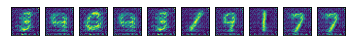

Epoch: [76] [  50/ 200] D_loss: 1.37293839, G_loss: 0.59266996
Epoch: [76] [ 100/ 200] D_loss: 0.99593830, G_loss: 0.64112020
Epoch: [76] [ 150/ 200] D_loss: 1.15167475, G_loss: 0.65033853
Epoch: [76] [ 200/ 200] D_loss: 0.98605859, G_loss: 0.77322400


<Figure size 72x720 with 0 Axes>

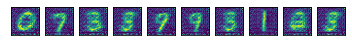

Epoch: [77] [  50/ 200] D_loss: 0.89671552, G_loss: 0.78877497
Epoch: [77] [ 100/ 200] D_loss: 1.17218435, G_loss: 0.62831694
Epoch: [77] [ 150/ 200] D_loss: 2.56302452, G_loss: 0.73298961
Epoch: [77] [ 200/ 200] D_loss: 1.33294606, G_loss: 0.74873996


<Figure size 72x720 with 0 Axes>

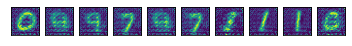

Epoch: [78] [  50/ 200] D_loss: 1.03953516, G_loss: 0.69593173
Epoch: [78] [ 100/ 200] D_loss: 0.95133615, G_loss: 0.75137961
Epoch: [78] [ 150/ 200] D_loss: 1.51114464, G_loss: 0.72882223
Epoch: [78] [ 200/ 200] D_loss: 4.53923893, G_loss: 0.69842887


<Figure size 72x720 with 0 Axes>

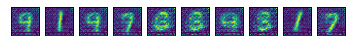

Epoch: [79] [  50/ 200] D_loss: 1.17680812, G_loss: 0.78171241
Epoch: [79] [ 100/ 200] D_loss: 1.81760585, G_loss: 0.73596007
Epoch: [79] [ 150/ 200] D_loss: 3.41564846, G_loss: 0.76044708
Epoch: [79] [ 200/ 200] D_loss: 1.52213860, G_loss: 0.68898916


<Figure size 72x720 with 0 Axes>

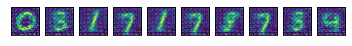

Epoch: [80] [  50/ 200] D_loss: 1.16347456, G_loss: 0.67821836
Epoch: [80] [ 100/ 200] D_loss: 2.01757288, G_loss: 0.69451892
Epoch: [80] [ 150/ 200] D_loss: 2.38812566, G_loss: 0.61656725
Epoch: [80] [ 200/ 200] D_loss: 1.22361279, G_loss: 0.68593460


<Figure size 72x720 with 0 Axes>

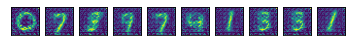

Epoch: [81] [  50/ 200] D_loss: 1.48291671, G_loss: 0.69711328
Epoch: [81] [ 100/ 200] D_loss: 1.01455832, G_loss: 0.66597676
Epoch: [81] [ 150/ 200] D_loss: 1.13861418, G_loss: 0.76098144
Epoch: [81] [ 200/ 200] D_loss: 1.30889559, G_loss: 0.71620518


<Figure size 72x720 with 0 Axes>

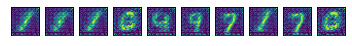

Epoch: [82] [  50/ 200] D_loss: 0.97681731, G_loss: 0.74562466
Epoch: [82] [ 100/ 200] D_loss: 3.36701369, G_loss: 0.72172856
Epoch: [82] [ 150/ 200] D_loss: 7.15139198, G_loss: 0.66498637
Epoch: [82] [ 200/ 200] D_loss: 16.46071625, G_loss: 0.73411316


<Figure size 72x720 with 0 Axes>

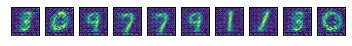

Epoch: [83] [  50/ 200] D_loss: 0.83141267, G_loss: 0.69578707
Epoch: [83] [ 100/ 200] D_loss: 1.02302730, G_loss: 0.73013264
Epoch: [83] [ 150/ 200] D_loss: 1.51353145, G_loss: 0.68205386
Epoch: [83] [ 200/ 200] D_loss: 1.54293001, G_loss: 0.74577028


<Figure size 72x720 with 0 Axes>

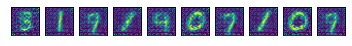

Epoch: [84] [  50/ 200] D_loss: 4.23527098, G_loss: 0.79135460
Epoch: [84] [ 100/ 200] D_loss: 1.18212962, G_loss: 0.76331091
Epoch: [84] [ 150/ 200] D_loss: 1.17660284, G_loss: 0.75313872
Epoch: [84] [ 200/ 200] D_loss: 1.23813057, G_loss: 0.70708293


<Figure size 72x720 with 0 Axes>

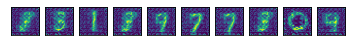

Epoch: [85] [  50/ 200] D_loss: 0.81736606, G_loss: 0.77678657
Epoch: [85] [ 100/ 200] D_loss: 0.94850266, G_loss: 0.71360934
Epoch: [85] [ 150/ 200] D_loss: 1.36647928, G_loss: 0.74014056
Epoch: [85] [ 200/ 200] D_loss: 1.07048726, G_loss: 0.65999854


<Figure size 72x720 with 0 Axes>

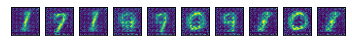

Epoch: [86] [  50/ 200] D_loss: 1.31957829, G_loss: 0.68420649
Epoch: [86] [ 100/ 200] D_loss: 1.31043708, G_loss: 0.72895473
Epoch: [86] [ 150/ 200] D_loss: 0.87410158, G_loss: 0.76257640
Epoch: [86] [ 200/ 200] D_loss: 2.75714374, G_loss: 0.65090728


<Figure size 72x720 with 0 Axes>

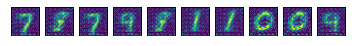

Epoch: [87] [  50/ 200] D_loss: 1.72078168, G_loss: 0.80105793
Epoch: [87] [ 100/ 200] D_loss: 1.60500956, G_loss: 0.71559650
Epoch: [87] [ 150/ 200] D_loss: 0.89942998, G_loss: 0.72907573
Epoch: [87] [ 200/ 200] D_loss: 5.22267246, G_loss: 0.60319477


<Figure size 72x720 with 0 Axes>

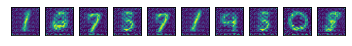

Epoch: [88] [  50/ 200] D_loss: 1.28406191, G_loss: 0.79902381
Epoch: [88] [ 100/ 200] D_loss: 1.03012657, G_loss: 0.76837879
Epoch: [88] [ 150/ 200] D_loss: 0.97157967, G_loss: 0.76067126
Epoch: [88] [ 200/ 200] D_loss: 0.95879209, G_loss: 0.68066770


<Figure size 72x720 with 0 Axes>

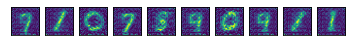

Epoch: [89] [  50/ 200] D_loss: 0.90965492, G_loss: 0.80291975
Epoch: [89] [ 100/ 200] D_loss: 1.92797482, G_loss: 0.59617078
Epoch: [89] [ 150/ 200] D_loss: 3.22201967, G_loss: 0.67246598
Epoch: [89] [ 200/ 200] D_loss: 1.73382330, G_loss: 0.78959513


<Figure size 72x720 with 0 Axes>

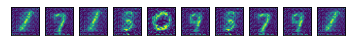

Epoch: [90] [  50/ 200] D_loss: 1.09889436, G_loss: 0.83849227
Epoch: [90] [ 100/ 200] D_loss: 1.31795979, G_loss: 0.76181674
Epoch: [90] [ 150/ 200] D_loss: 3.63995290, G_loss: 0.64829206
Epoch: [90] [ 200/ 200] D_loss: 1.46402121, G_loss: 0.76196992


<Figure size 72x720 with 0 Axes>

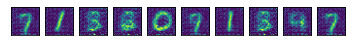

Epoch: [91] [  50/ 200] D_loss: 7.89312172, G_loss: 0.76560396
Epoch: [91] [ 100/ 200] D_loss: 1.08452332, G_loss: 0.76752532
Epoch: [91] [ 150/ 200] D_loss: 4.85469294, G_loss: 0.72158873
Epoch: [91] [ 200/ 200] D_loss: 1.04921770, G_loss: 0.73852056


<Figure size 72x720 with 0 Axes>

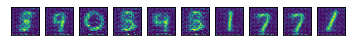

Epoch: [92] [  50/ 200] D_loss: 1.08446836, G_loss: 0.79724878
Epoch: [92] [ 100/ 200] D_loss: 8.59798717, G_loss: 0.71233147
Epoch: [92] [ 150/ 200] D_loss: 0.93582112, G_loss: 0.84487087
Epoch: [92] [ 200/ 200] D_loss: 1.50084865, G_loss: 0.73123437


<Figure size 72x720 with 0 Axes>

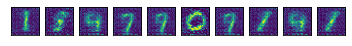

Epoch: [93] [  50/ 200] D_loss: 0.79606605, G_loss: 0.73209250
Epoch: [93] [ 100/ 200] D_loss: 5.44999361, G_loss: 0.73177862
Epoch: [93] [ 150/ 200] D_loss: 1.17099428, G_loss: 0.71279263
Epoch: [93] [ 200/ 200] D_loss: 0.88549685, G_loss: 0.77946591


<Figure size 72x720 with 0 Axes>

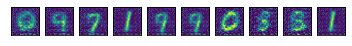

Epoch: [94] [  50/ 200] D_loss: 0.98528588, G_loss: 0.78298032
Epoch: [94] [ 100/ 200] D_loss: 0.89086556, G_loss: 0.79083240
Epoch: [94] [ 150/ 200] D_loss: 1.31327987, G_loss: 0.79548883
Epoch: [94] [ 200/ 200] D_loss: 0.82640105, G_loss: 0.70142817


<Figure size 72x720 with 0 Axes>

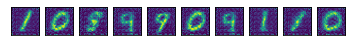

Epoch: [95] [  50/ 200] D_loss: 1.07353020, G_loss: 0.72030938
Epoch: [95] [ 100/ 200] D_loss: 1.00234711, G_loss: 0.72962660
Epoch: [95] [ 150/ 200] D_loss: 1.15413094, G_loss: 0.80640012
Epoch: [95] [ 200/ 200] D_loss: 1.02034521, G_loss: 0.66633105


<Figure size 72x720 with 0 Axes>

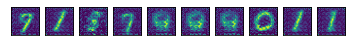

Epoch: [96] [  50/ 200] D_loss: 6.11517048, G_loss: 0.74632758
Epoch: [96] [ 100/ 200] D_loss: 7.85903549, G_loss: 0.71925652
Epoch: [96] [ 150/ 200] D_loss: 1.79367113, G_loss: 0.79512161
Epoch: [96] [ 200/ 200] D_loss: 1.35223997, G_loss: 0.74320650


<Figure size 72x720 with 0 Axes>

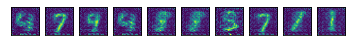

Epoch: [97] [  50/ 200] D_loss: 0.88298059, G_loss: 0.77994573
Epoch: [97] [ 100/ 200] D_loss: 8.09983158, G_loss: 0.71012121
Epoch: [97] [ 150/ 200] D_loss: 2.31221628, G_loss: 0.69788450
Epoch: [97] [ 200/ 200] D_loss: 4.53085041, G_loss: 0.69350445


<Figure size 72x720 with 0 Axes>

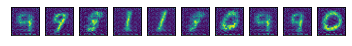

Epoch: [98] [  50/ 200] D_loss: 1.09480596, G_loss: 0.75669771
Epoch: [98] [ 100/ 200] D_loss: 1.69186950, G_loss: 0.74988258
Epoch: [98] [ 150/ 200] D_loss: 0.89221632, G_loss: 0.68363452
Epoch: [98] [ 200/ 200] D_loss: 1.16350770, G_loss: 0.78620929


<Figure size 72x720 with 0 Axes>

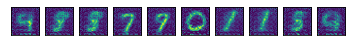

Epoch: [99] [  50/ 200] D_loss: 2.80428648, G_loss: 0.65146911
Epoch: [99] [ 100/ 200] D_loss: 1.32132721, G_loss: 0.71164012
Epoch: [99] [ 150/ 200] D_loss: 0.87700689, G_loss: 0.75279593
Epoch: [99] [ 200/ 200] D_loss: 0.94102967, G_loss: 0.81972146


<Figure size 72x720 with 0 Axes>

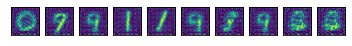

Epoch: [100] [  50/ 200] D_loss: 2.14538050, G_loss: 0.75269139
Epoch: [100] [ 100/ 200] D_loss: 8.54867649, G_loss: 0.68288916
Epoch: [100] [ 150/ 200] D_loss: 2.07692289, G_loss: 0.66013682
Epoch: [100] [ 200/ 200] D_loss: 3.52613258, G_loss: 0.69590908


<Figure size 72x720 with 0 Axes>

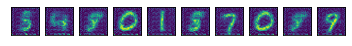

Training finished!


In [44]:
params = {'beta1': 0.5, 'beta2': 0.9,'lr_g':0.002,'lr_d':0.002,'max_epochs':100}

params['z_dim'] = 1
params['base_size'] = 64

gan = GAN(params)


gan.train()

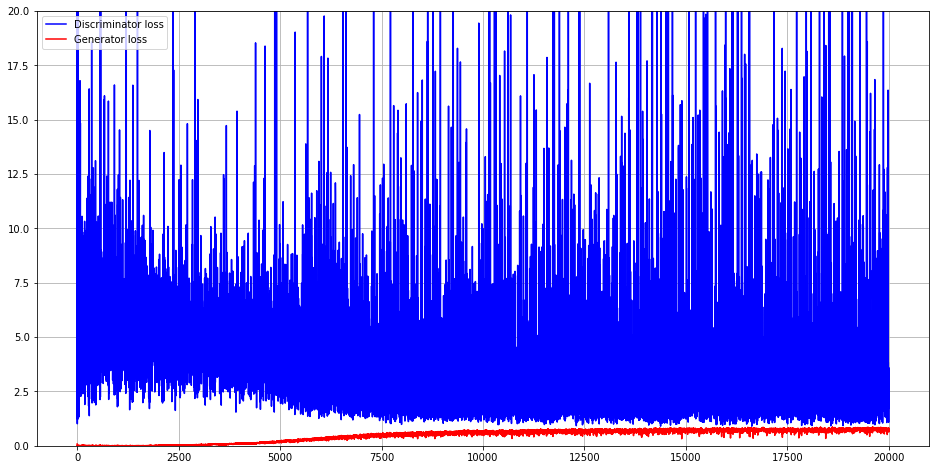

In [36]:

plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['D_loss'],c='b')
s=plt.plot(gan.train_hist['G_loss'],c='r')
s = plt.ylim((0,20))
s = plt.grid()
s=plt.legend(('Discriminator loss','Generator loss'))

# plotting inception Score for model with latent dim =1


[3.603496, 4.768294, 4.5126505, 4.9725404, 4.863921, 4.50452, 4.3576756, 3.855531, 3.8979917, 4.560994, 4.7617846, 4.959994, 4.383441, 4.5076227, 5.159664, 4.481493, 4.866556, 4.302198, 4.4048567, 4.3196616, 4.6716337, 4.435594, 4.1166825, 4.236539, 3.9135692, 4.0301495, 4.259207, 4.3063717, 4.098365, 4.100654, 3.9812825, 4.3219113, 4.088414, 3.7355034, 4.1263943, 4.3421617, 4.226636, 4.660936, 4.8310556, 4.575088, 4.4825764, 4.6916146, 4.7492967, 4.6394463, 4.7564774, 4.9096475, 4.6412625, 4.6632767, 4.835482, 4.8306775, 4.5756087, 4.192922, 4.942333, 4.8025765, 4.7037554, 4.6419024, 4.4923134, 4.64806, 4.208188, 4.851732, 4.40767, 4.3567343, 4.6172957, 4.661907, 4.587736, 5.03289, 4.306573, 4.838383, 4.377837, 4.379924, 4.628848, 4.978087, 4.8307495, 4.8271995, 4.8106084, 5.144473, 4.887771, 5.1482735, 4.6352262, 4.9353204, 4.526723, 4.8113375, 4.2736287, 4.2479634, 4.5218773, 4.587475, 4.570838, 4.452826, 4.4382725, 4.726548, 4.65158, 4.7530174, 4.9224734, 4.803847, 4.8608017, 4.614

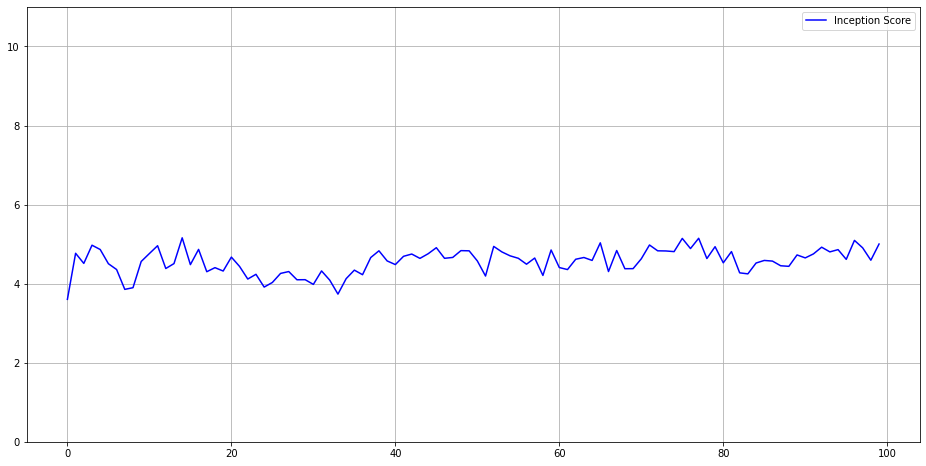

In [45]:

plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['IS_score'],c='b')
s = plt.ylim((0,11))
s = plt.grid()
s=plt.legend(('Inception Score','Generator loss'))
print(gan.train_hist['IS_score'])

# model with latent dim 10

1
training start!!
Epoch: [ 1] [  50/ 200] D_loss: 8.64731789, G_loss: 0.00857484
Epoch: [ 1] [ 100/ 200] D_loss: 4.89157295, G_loss: 0.00039119
Epoch: [ 1] [ 150/ 200] D_loss: 5.27208042, G_loss: 0.00031644
Epoch: [ 1] [ 200/ 200] D_loss: 6.74508142, G_loss: 0.00147778
Training at Epoch:
0


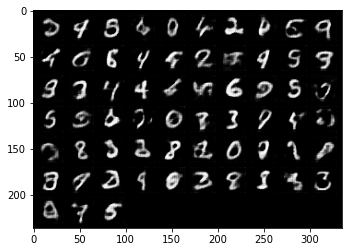

is_score 6.269



is_score 5.630236



is_score 6.085306



is_score 6.483461



is_score 5.536194



is_score 6.3251147



is_score 5.8424735



is_score 4.779943



is_score 4.9241



is_score 5.390148



Epoch: [ 2] [  50/ 200] D_loss: 3.05474710, G_loss: 0.00325292
Epoch: [ 2] [ 100/ 200] D_loss: 5.26945543, G_loss: 0.00051057
Epoch: [ 2] [ 150/ 200] D_loss: 5.68606377, G_loss: 0.00474524
Epoch: [ 2] [ 200/ 200] D_loss: 6.52041435, G_loss: 0.01373011
Epoch: [ 3] [  50/ 200] D_loss: 4.45051289, G_loss: 0.00000638
Epoch: [ 3] [ 100/ 200] D_loss: 5.57364225, G_loss: 0.00036430
Epoch: [ 3] [ 150/ 200] D_loss: 16.54135323, G_loss: 0.01932114
Epoch: [ 3] [ 200/ 200] D_loss: 5.62182236, G_loss: 0.00013345
Epoch: [ 4] [  50/ 200] D_loss: 4.33048248, G_loss: 0.00557613
Epoch: [ 4] [ 100/ 200] D_loss: 3.45420885, G_loss: 0.00308228
Epoch: [ 4] [ 150/ 200] D_loss: 7.89076662, G_loss: 0.00203377
Epoch: [ 4] [ 200/ 200] D_loss: 6.60580826, G_loss: 0.00335735
Epoch: [ 5] [  50/ 200] D_loss: 3.94

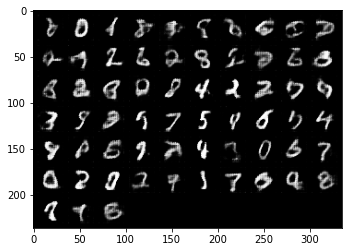

is_score 5.9202237



is_score 5.6598134



is_score 6.37622



is_score 5.201059



is_score 6.909362



is_score 4.542541



is_score 6.0651684



is_score 6.471991



is_score 6.0501256



is_score 4.7109



Epoch: [12] [  50/ 200] D_loss: 4.73975086, G_loss: 0.00921500
Epoch: [12] [ 100/ 200] D_loss: 4.12427425, G_loss: 0.02048463
Epoch: [12] [ 150/ 200] D_loss: 3.88920879, G_loss: 0.02598143
Epoch: [12] [ 200/ 200] D_loss: 8.70987320, G_loss: 0.02841169
Epoch: [13] [  50/ 200] D_loss: 5.03809404, G_loss: 0.01175028
Epoch: [13] [ 100/ 200] D_loss: 3.72191811, G_loss: 0.01901954
Epoch: [13] [ 150/ 200] D_loss: 5.69168377, G_loss: 0.02264047
Epoch: [13] [ 200/ 200] D_loss: 5.90888309, G_loss: 0.03057778
Epoch: [14] [  50/ 200] D_loss: 4.84774590, G_loss: 0.04010731
Epoch: [14] [ 100/ 200] D_loss: 4.91285849, G_loss: 0.04996216
Epoch: [14] [ 150/ 200] D_loss: 4.09804916, G_loss: 0.04460806
Epoch: [14] [ 200/ 200] D_loss: 5.18253231, G_loss: 0.04688632
Epoch: [15] [  50/ 200] D_loss: 3

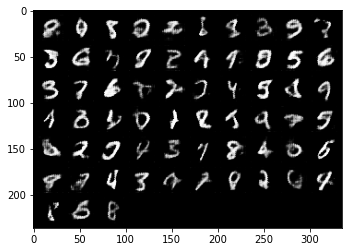

is_score 5.415228



is_score 6.3979325



is_score 5.8942857



is_score 4.998159



is_score 6.9045916



is_score 5.6372676



is_score 5.8894134



is_score 4.7349377



is_score 5.5018992



is_score 5.448154



Epoch: [22] [  50/ 200] D_loss: 5.29980612, G_loss: 0.12398845
Epoch: [22] [ 100/ 200] D_loss: 6.38993168, G_loss: 0.10571468
Epoch: [22] [ 150/ 200] D_loss: 3.89590168, G_loss: 0.12569350
Epoch: [22] [ 200/ 200] D_loss: 2.58073354, G_loss: 0.09623474
Epoch: [23] [  50/ 200] D_loss: 3.17693758, G_loss: 0.11432147
Epoch: [23] [ 100/ 200] D_loss: 2.59014463, G_loss: 0.12467331
Epoch: [23] [ 150/ 200] D_loss: 3.91868591, G_loss: 0.12417483
Epoch: [23] [ 200/ 200] D_loss: 4.03830099, G_loss: 0.13871211
Epoch: [24] [  50/ 200] D_loss: 2.75393319, G_loss: 0.13125044
Epoch: [24] [ 100/ 200] D_loss: 4.50547314, G_loss: 0.12132263
Epoch: [24] [ 150/ 200] D_loss: 4.75302362, G_loss: 0.15693349
Epoch: [24] [ 200/ 200] D_loss: 3.54349399, G_loss: 0.17725956
Epoch: [25] [  50/ 200] D_l

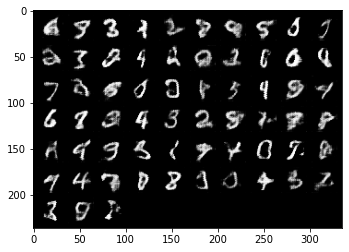

is_score 6.2467966



is_score 6.4759803



is_score 5.456226



is_score 5.691292



is_score 5.923859



is_score 5.5827546



is_score 5.0476217



is_score 6.120119



is_score 5.4980273



is_score 6.8612523



Epoch: [32] [  50/ 200] D_loss: 4.43405294, G_loss: 0.28835678
Epoch: [32] [ 100/ 200] D_loss: 2.20278144, G_loss: 0.22180653
Epoch: [32] [ 150/ 200] D_loss: 5.19593430, G_loss: 0.25683445
Epoch: [32] [ 200/ 200] D_loss: 4.94399977, G_loss: 0.26817620
Epoch: [33] [  50/ 200] D_loss: 2.42767000, G_loss: 0.24237192
Epoch: [33] [ 100/ 200] D_loss: 3.49044704, G_loss: 0.26173794
Epoch: [33] [ 150/ 200] D_loss: 5.49911070, G_loss: 0.23965141
Epoch: [33] [ 200/ 200] D_loss: 4.21925688, G_loss: 0.31823111
Epoch: [34] [  50/ 200] D_loss: 5.39568949, G_loss: 0.25084215
Epoch: [34] [ 100/ 200] D_loss: 5.41113281, G_loss: 0.27832282
Epoch: [34] [ 150/ 200] D_loss: 4.29990101, G_loss: 0.22104353
Epoch: [34] [ 200/ 200] D_loss: 3.54401922, G_loss: 0.26668787
Epoch: [35] [  50/ 200] D_lo

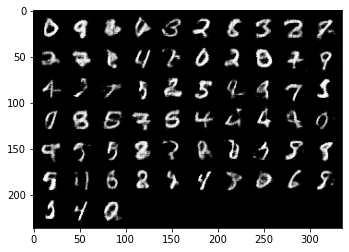

is_score 3.9177396



is_score 4.5190625



is_score 5.131457



is_score 5.5279865



is_score 6.170079



is_score 5.5685396



is_score 4.4313116



is_score 5.4952984



is_score 6.0011973



is_score 5.9226475



Epoch: [42] [  50/ 200] D_loss: 13.89215183, G_loss: 0.42218247
Epoch: [42] [ 100/ 200] D_loss: 2.23284340, G_loss: 0.42257246
Epoch: [42] [ 150/ 200] D_loss: 2.86384964, G_loss: 0.36975780
Epoch: [42] [ 200/ 200] D_loss: 3.14453411, G_loss: 0.37579879
Epoch: [43] [  50/ 200] D_loss: 1.27345657, G_loss: 0.36045578
Epoch: [43] [ 100/ 200] D_loss: 2.06508136, G_loss: 0.43238023
Epoch: [43] [ 150/ 200] D_loss: 2.37053013, G_loss: 0.40503651
Epoch: [43] [ 200/ 200] D_loss: 4.90369368, G_loss: 0.44525400
Epoch: [44] [  50/ 200] D_loss: 5.22116280, G_loss: 0.37563476
Epoch: [44] [ 100/ 200] D_loss: 2.85715199, G_loss: 0.40518555
Epoch: [44] [ 150/ 200] D_loss: 2.67133760, G_loss: 0.39611059
Epoch: [44] [ 200/ 200] D_loss: 5.50105619, G_loss: 0.41502374
Epoch: [45] [  50/ 200] D

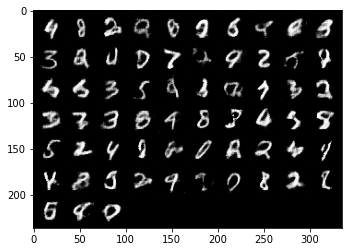

is_score 5.507284



is_score 6.2769084



is_score 7.4489055



is_score 7.3593736



is_score 5.8870387



is_score 6.717069



is_score 5.606042



is_score 6.6170053



is_score 6.2312837



is_score 5.1448097



Epoch: [52] [  50/ 200] D_loss: 1.99921417, G_loss: 0.58609295
Epoch: [52] [ 100/ 200] D_loss: 1.63032365, G_loss: 0.53409493
Epoch: [52] [ 150/ 200] D_loss: 1.61316276, G_loss: 0.50880063
Epoch: [52] [ 200/ 200] D_loss: 2.53811502, G_loss: 0.46183741
Epoch: [53] [  50/ 200] D_loss: 2.53686714, G_loss: 0.54977334
Epoch: [53] [ 100/ 200] D_loss: 1.27546787, G_loss: 0.54104769
Epoch: [53] [ 150/ 200] D_loss: 4.32702303, G_loss: 0.46159261
Epoch: [53] [ 200/ 200] D_loss: 3.68378496, G_loss: 0.51934981
Epoch: [54] [  50/ 200] D_loss: 2.99542356, G_loss: 0.52819848
Epoch: [54] [ 100/ 200] D_loss: 9.77824211, G_loss: 0.53467220
Epoch: [54] [ 150/ 200] D_loss: 2.48587084, G_loss: 0.51969045
Epoch: [54] [ 200/ 200] D_loss: 1.59105659, G_loss: 0.57138872
Epoch: [55] [  50/ 200] D_l

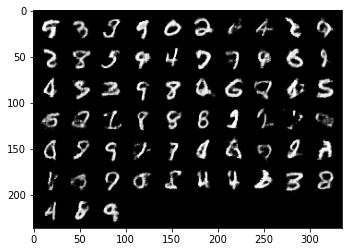

is_score 6.702648



is_score 6.7710133



is_score 6.5292335



is_score 6.1875386



is_score 7.4979563



is_score 5.283409



is_score 6.473942



is_score 5.634809



is_score 4.201981



is_score 5.272359



Epoch: [62] [  50/ 200] D_loss: 1.22147417, G_loss: 0.60362422
Epoch: [62] [ 100/ 200] D_loss: 2.04313707, G_loss: 0.58974040
Epoch: [62] [ 150/ 200] D_loss: 1.78481126, G_loss: 0.58860505
Epoch: [62] [ 200/ 200] D_loss: 1.33539200, G_loss: 0.59180856
Epoch: [63] [  50/ 200] D_loss: 1.43404341, G_loss: 0.47287700
Epoch: [63] [ 100/ 200] D_loss: 2.53430033, G_loss: 0.61335230
Epoch: [63] [ 150/ 200] D_loss: 3.25886512, G_loss: 0.61785883
Epoch: [63] [ 200/ 200] D_loss: 1.31414270, G_loss: 0.61161363
Epoch: [64] [  50/ 200] D_loss: 1.12216222, G_loss: 0.58768010
Epoch: [64] [ 100/ 200] D_loss: 2.85771418, G_loss: 0.52284938
Epoch: [64] [ 150/ 200] D_loss: 3.57875156, G_loss: 0.62727666
Epoch: [64] [ 200/ 200] D_loss: 1.61193991, G_loss: 0.62153894
Epoch: [65] [  50/ 200] D_loss

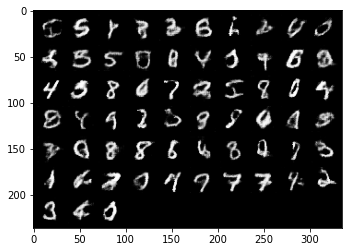

is_score 4.990436



is_score 8.003196



is_score 5.526504



is_score 5.2001944



is_score 5.1034927



is_score 5.83607



is_score 6.4354415



is_score 6.0463305



is_score 6.2935596



is_score 5.9093323



Epoch: [72] [  50/ 200] D_loss: 1.04345942, G_loss: 0.63189501
Epoch: [72] [ 100/ 200] D_loss: 1.34312892, G_loss: 0.52719200
Epoch: [72] [ 150/ 200] D_loss: 4.03114891, G_loss: 0.62537795
Epoch: [72] [ 200/ 200] D_loss: 1.45214033, G_loss: 0.67838538
Epoch: [73] [  50/ 200] D_loss: 2.05654120, G_loss: 0.58388549
Epoch: [73] [ 100/ 200] D_loss: 1.15866315, G_loss: 0.63058209
Epoch: [73] [ 150/ 200] D_loss: 1.54870629, G_loss: 0.67579842
Epoch: [73] [ 200/ 200] D_loss: 3.22277498, G_loss: 0.63150179
Epoch: [74] [  50/ 200] D_loss: 1.56364787, G_loss: 0.63626862
Epoch: [74] [ 100/ 200] D_loss: 6.30242348, G_loss: 0.60368496
Epoch: [74] [ 150/ 200] D_loss: 1.40925276, G_loss: 0.63671178
Epoch: [74] [ 200/ 200] D_loss: 7.50380135, G_loss: 0.64249897
Epoch: [75] [  50/ 200] D_los

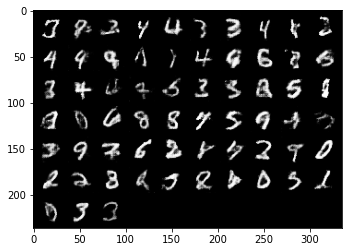

is_score 5.4348855



is_score 5.9164743



is_score 7.3468666



is_score 5.718275



is_score 5.1775923



is_score 4.3486233



is_score 6.0207233



is_score 5.1841097



is_score 5.580998



is_score 4.2957597



Epoch: [82] [  50/ 200] D_loss: 1.28675342, G_loss: 0.67009526
Epoch: [82] [ 100/ 200] D_loss: 1.89216685, G_loss: 0.69672954
Epoch: [82] [ 150/ 200] D_loss: 1.61248219, G_loss: 0.69908929
Epoch: [82] [ 200/ 200] D_loss: 3.22215676, G_loss: 0.66982186
Epoch: [83] [  50/ 200] D_loss: 1.45373845, G_loss: 0.63650775
Epoch: [83] [ 100/ 200] D_loss: 1.78569174, G_loss: 0.62556016
Epoch: [83] [ 150/ 200] D_loss: 2.50698805, G_loss: 0.69720817
Epoch: [83] [ 200/ 200] D_loss: 2.63038015, G_loss: 0.63299203
Epoch: [84] [  50/ 200] D_loss: 1.31021464, G_loss: 0.69804287
Epoch: [84] [ 100/ 200] D_loss: 1.52335835, G_loss: 0.68999535
Epoch: [84] [ 150/ 200] D_loss: 1.03607523, G_loss: 0.63512874
Epoch: [84] [ 200/ 200] D_loss: 1.18326938, G_loss: 0.67524415
Epoch: [85] [  50/ 200] D_

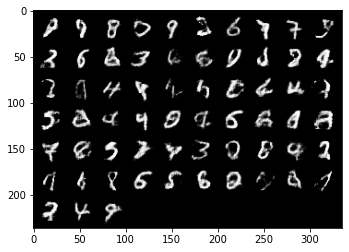

is_score 6.6621637



is_score 4.624568



is_score 4.980358



is_score 4.457155



is_score 5.0775313



is_score 5.6354985



is_score 5.099855



is_score 6.2572393



is_score 5.9477425



is_score 5.2680044



Epoch: [92] [  50/ 200] D_loss: 1.07356358, G_loss: 0.69574416
Epoch: [92] [ 100/ 200] D_loss: 1.25960398, G_loss: 0.59116668
Epoch: [92] [ 150/ 200] D_loss: 2.01964402, G_loss: 0.72308719
Epoch: [92] [ 200/ 200] D_loss: 1.37779474, G_loss: 0.71918106
Epoch: [93] [  50/ 200] D_loss: 1.34247327, G_loss: 0.72941101
Epoch: [93] [ 100/ 200] D_loss: 14.95458794, G_loss: 0.70454150
Epoch: [93] [ 150/ 200] D_loss: 1.64420211, G_loss: 0.68520194
Epoch: [93] [ 200/ 200] D_loss: 5.27821732, G_loss: 0.68814695
Epoch: [94] [  50/ 200] D_loss: 1.10153270, G_loss: 0.74749827
Epoch: [94] [ 100/ 200] D_loss: 1.90785539, G_loss: 0.67426687
Epoch: [94] [ 150/ 200] D_loss: 1.01648498, G_loss: 0.68137550
Epoch: [94] [ 200/ 200] D_loss: 1.82855487, G_loss: 0.58292913
Epoch: [95] [  50/ 200] D_l

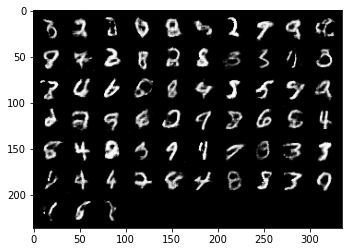

is_score 5.5806475



is_score 5.355608



is_score 5.081941



is_score 5.977716



is_score 5.6965284



is_score 7.163452



is_score 5.7486825



is_score 5.4249845



is_score 5.1575923



is_score 5.8640757



Epoch: [102] [  50/ 200] D_loss: 3.20114231, G_loss: 0.64910638
Epoch: [102] [ 100/ 200] D_loss: 2.65891266, G_loss: 0.68391299
Epoch: [102] [ 150/ 200] D_loss: 1.33599234, G_loss: 0.66469228
Epoch: [102] [ 200/ 200] D_loss: 1.88684654, G_loss: 0.74402440
Training finished!


In [ ]:
params = {'beta1': 0.5, 'beta2': 0.9,'lr_g':0.002,'lr_d':0.002,'max_epochs':102}

params['z_dim'] = 10
params['base_size'] = 64

gan2 = GAN(params)


gan2.train()

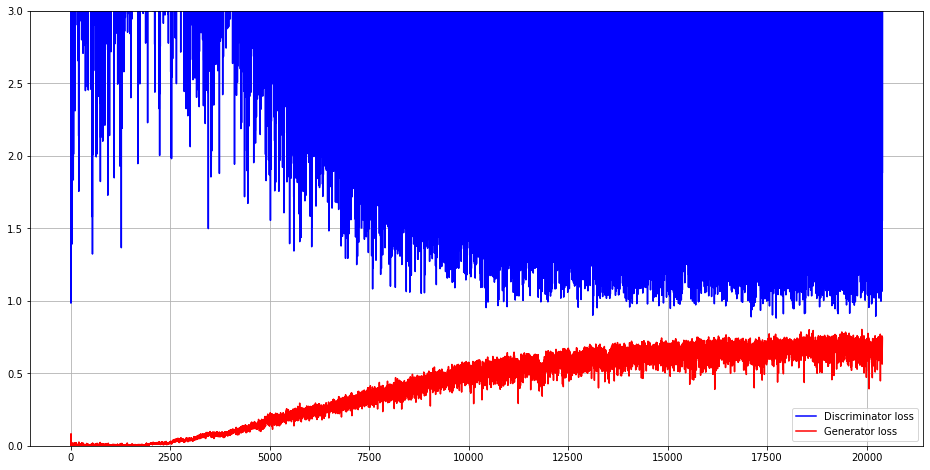

In [ ]:

plt.figure(figsize=(16,8))
s=plt.plot(gan2.train_hist['D_loss'],c='b')
s=plt.plot(gan2.train_hist['G_loss'],c='r')
s = plt.ylim((0,3))
s = plt.grid()
s=plt.legend(('Discriminator loss','Generator loss'))

[5.726598, 5.79074, 5.682187, 5.890393, 5.268532, 6.2795725, 6.055489, 5.9344554, 5.502431, 5.4010115, 5.705123]


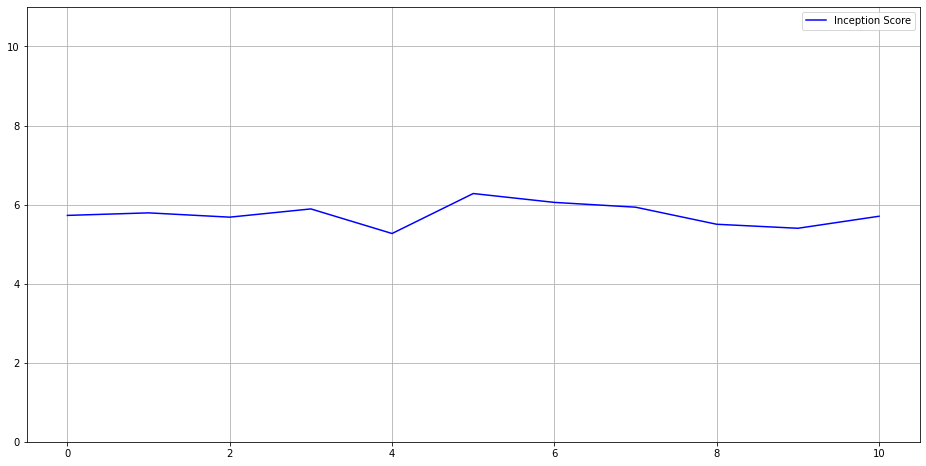

In [ ]:
plt.figure(figsize=(16,8))
s=plt.plot(gan2.train_hist['IS_score'],c='b')
s = plt.ylim((0,11))
s = plt.grid()
s=plt.legend(('Inception Score','Generator loss'))
print(gan2.train_hist['IS_score'])